In [4]:
!pip install --upgrade pip --user

  Using cached https://files.pythonhosted.org/packages/54/0c/d01aa759fdc501a58f431eb594a17495f15b88da142ce14b5845662c13f3/pip-20.0.2-py2.py3-none-any.whl


In [2]:
!pip install bayesian-optimization

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import cv2
import csv
import scipy
from scipy.io import loadmat,savemat
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

#from PIL import Image
import time
import random
import pandas as pd
from skimage.transform import resize
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import os.path

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dense,AveragePooling1D,Flatten,TimeDistributed,Dropout

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

In [4]:
print(tf.version.VERSION)

2.0.0


In [5]:
def CreateDataList(TaskList):
'''
This function extracts mouse, cursor and fixation data from the user files

Parameters:
    TaskList (list) - list of user tasks or UI 
returns:
    complete extracted mouse, cursor and fixation data for each user
   
'''

    User_mouse_List = []
    User_cursor_List = []
    User_fixation_List = []


    for n in range(len(TaskList)):
        TaskName = TaskList[n]
        #print(TaskName)
        TaskListIndex = TaskList.index(TaskName)
        #print(TaskListIndex)
        ts_input_mouse = mat['guidata'][0][TaskListIndex][0][0][2][0][0][0][0]
        ts_input_cursor = mat['guidata'][0][TaskListIndex][0][0][2][0][0][3][0]
        ts_output_fixation = mat['guidata'][0][TaskListIndex][0][0][3][0]

# print(ts_output_fixation)

############################# Extract Timestamp , X and Y ########################################

############################## MOUSE ############################################
        Tmouse_List = []

        for k in ts_input_mouse:
            if k['event'][0][0][0] == "move" and k['type'][0][0] =='mouse':
#             # if k['timestamp'][0][0][0][0] not in Tmouse_dict:
#             #     Tmouse_dict[k['timestamp'][0][0][0][0]] = []
                    Tmouse_List.append((k['timestamp'][0][0][0][0], k['x'][0][0][0][0], k['y'][0][0][0][0]))

            # print(k.shape)
            # npInputArray = np.asarray(Tmouse_dict)
            # pd.DataFrame(npInputArray).to_csv("./Temporal_mouse.csv",  mode='a', header=None, index=None)
        User_mouse_List.append((Tmouse_List))
############################## CURSOR ############################################
        Tcursor_List = []

        for i in ts_input_cursor:
            if i['type'][0][0][0] == "caret":
                Tcursor_List.append((i['timestamp'][0][0][0][0], i['x'][0][0][0][0], i['y'][0][0][0][0]))

         # npInputArray = np.asarray(Tcursor_dict)
         # pd.DataFrame(npInputArray).to_csv("./Temporal_cursor.csv",  mode='a', header=None, index=None)
        User_cursor_List.append((Tcursor_List))
############################## FIXATION ############################################
        Tfixation_List = []
        X_thres_List = []
        Y_thres_List = []

        for i in ts_output_fixation:
            if i['event'][0][0][0] == "fixation":
                Tfixation_List.append((int(i['timestamp'][0][0][0][0]), int(i['x'][0][0][0]), int(i['y'][0][0][0])))


         # npInputArray = np.asarray(Tfixation_dict)
         # pd.DataFrame(npInputArray).to_csv("./Temporal_fixation.csv",  mode='a', header=None, index=None)

        # print(len(Tfixation_List), len(X_thres_List), len(Y_thres_List))
        User_fixation_List.append((Tfixation_List))

    return User_mouse_List, User_cursor_List, User_fixation_List

############################### NORMALIZE TIMESTAMP #################################################

def normalize(dataList):
'''
This function gives output in the range 0-1
Parameters: 
     dataList (list) - timestamp values to be normalized 
returns:
       normalised list of timestamp  values 
'''
    normTimeList = []
    min_time = dataList[0][0][0]         ## ascending order time data, first element of list =  min. time
    max_time = dataList[-1][-1][0]       ## ascending order time data, last element of list =  max. time
    #print(min_time, max_time)
    diff_time = max_time - min_time
    master_norm_List =[]
############################## min.time and max.time varied for each user ################
    for timeIter in dataList:
        #userIter = dataList[timeIter]
        normTimeList = []
        min_time = timeIter[0][0]           # find min.time for each user
        max_time = timeIter[-1][0]          # find max.time for each user
        diff_time = max_time - min_time     

        for sublist in timeIter:
            norm_time = (sublist[0] - min_time)/ diff_time         # all time points will be between 0 and 1
            normTimeList.append([norm_time, sublist[1], sublist[2]])
        master_norm_List.append((normTimeList))

       
    return master_norm_List


########################### Interpolate and Sample 400 time points ############################################
def InterpolateSample(ThresTimeList):
'''
This function interpolates given list of inputs

Parameters:
    ThresTimeList: list of values to be interpolated (mouse,cursor,fixation)
returns:
    interpolated and evenly sampled list (mouse,cursor,fixation)
    
'''
    
    All_TimeValues = []


    for task in ThresTimeList:
        Time_values = []
        X_pos = []
        Y_pos = []
        for line in task:
            Time_values.append(line[0])
            X_pos.append(line[1])
            Y_pos.append(line[2])
        X_plot = interp1d(Time_values, X_pos, kind='linear')
        Y_plot = interp1d(Time_values, Y_pos, kind='linear')

        ######## Sampling 400 time points ###############
        TimeValues_new = np.linspace(0, 1, num=400) ## find evenly sampled 400 points from interpolated curve
        Pos_X_new = X_plot(TimeValues_new)   ## find evenly sampled 400  X points from interpolated curve
        Pos_Y_new = Y_plot(TimeValues_new)  ## find evenly sampled 400 Y points from interpolated curve
        Final_sampled = [TimeValues_new, Pos_X_new, Pos_Y_new]
        All_TimeValues.append(Final_sampled)

    # plt.plot(Time_values, X_pos, 'o', TimeValues_new, Pos_X_new, '-')  ##### Plot interpolated X and Y with sampled time points
    # plt.title('Ground truth')
    # plt.xlabel('Normalised time')
    # plt.ylabel('x')
    # # plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
    # plt.show()

   # print('Shape interpolated:', np.shape(All_TimeValues))
    return All_TimeValues

In [9]:
# script_dir = os.path.dirname(os.path.abspath(__file__))
Mouse_block=[]
cursor_block =[]
Fixation_block=[]
Total_Interfaces = []

##### give the path of dataset ###########

datasetdir = "/home/kkjk/Dataset/"

listOfUsersMatFiles = ["Alice.mat", "Charlotte.mat", "Irina.mat", "Konstantin.mat", "Mike.mat", "Lokesh.mat","Russa.mat", "Sampath.mat", "Somendra.mat", "Srikanth.mat", "Varun.mat"]
import csv
for matfile in listOfUsersMatFiles:
    mat = scipy.io.loadmat(datasetdir + matfile)
    totalInterfaces_count = len(mat['guidata'][0])
    totalInterfaces = mat['guidata'][0]

    TaskList=[]
    print('Total Interfaces:', totalInterfaces_count)
    for i in range(totalInterfaces_count):
        TaskList.append(mat['guidata'][0][i][0][0][0][0])  # List of all tasks for User
### call CreateDataList to obtain data as list #########
    A_mouse , A_cursor, A_fixation = CreateDataList(TaskList)
    #print('MouseList:', len(A_mouse), 'Cursor:', len(A_cursor))

    ############################################# FUNCTION CALL NORMALIZATION ############################################
    norm_A_mouse = normalize(A_mouse)
    norm_A_cursor = normalize(A_cursor)
    norm_A_fixation = normalize(A_fixation)


    ############################################### FUNCTION CALL INTERPOLATION & SAMPLING ###############################
    NTS_A_mouse = InterpolateSample(norm_A_mouse)
    NTS_A_cursor = InterpolateSample(norm_A_cursor)
    NTS_A_fixation = InterpolateSample(norm_A_fixation)
    # window_size=30
    
    print(np.shape(NTS_A_mouse))
    # print('NTS_A_mouse:', np.shape(NTS_A_mouse))  ### totalInterfaces,3,400
    for i in range(totalInterfaces_count):
      # print(i)
      # for j in range(0,400):
      Mouse_block.append(np.concatenate((NTS_A_mouse[i][1]/1920, NTS_A_mouse[i][2]/1200)))
      cursor_block.append(np.concatenate((NTS_A_cursor[i][1]/1920, NTS_A_cursor[i][2]/1200)))
      Fixation_block.append(np.concatenate((NTS_A_fixation[i][1]/1920,NTS_A_fixation[i][2]/1200)))
      Total_Interfaces.append(totalInterfaces)

Mouse_block=np.array(np.reshape(Mouse_block,(245,2,400)))
cursor_block =np.array(np.reshape(cursor_block,(245,2,400)))
Fixation_block=np.array(np.reshape(Fixation_block,(245,2,400)))
Total_Interfaces=np.array(Total_Interfaces)

print(Mouse_block.shape)        
print(cursor_block.shape) 
print(Fixation_block.shape) 
print(Total_Interfaces.shape)      


    
   


Total Interfaces: 27
(27, 3, 400)
Total Interfaces: 28
(28, 3, 400)
Total Interfaces: 33
(33, 3, 400)
Total Interfaces: 27
(27, 3, 400)
Total Interfaces: 25
(25, 3, 400)
Total Interfaces: 28
(28, 3, 400)
Total Interfaces: 19
(19, 3, 400)
Total Interfaces: 7
(7, 3, 400)
Total Interfaces: 13
(13, 3, 400)
Total Interfaces: 19
(19, 3, 400)
Total Interfaces: 19
(19, 3, 400)
(245, 2, 400)
(245, 2, 400)
(245, 2, 400)
(245,)


In [13]:
def input_windowing(Mouse_block,cursor_block,Fixation_block,Total_interfaces,window_size):
'''
This function defines input size for LSTM model
Parameters:
    Mouse_block (nd array): mouse data block after interpolation
    cursor_block (nd array):cursor data block after interpolation
    Fixation_block (nd array): fixation data block after interpolation
    Total_interfaces (int): count of user tasks
    window_size: time window for grouping inputs. The number of previous inputs to predict current fixation.
returns:
    complete input dataset and labels (fixations) as sequences of window size
'''
  
    X_block=[]
    Y_block=[]
    data=[]
    label=[]
  # print('total interfaces from in window:',Total_Interfaces.shape[0])
    for i in range(Total_Interfaces.shape[0]):
        for j in range(400 - window_size ):
            #print('j for 20:', j)
            X_block.append(np.column_stack((Mouse_block[i][0][j:j + window_size],
                               cursor_block[i][0][j:j + window_size],
                               Mouse_block[i][1][j:j + window_size],
                               cursor_block[i][1][j:j + window_size])))

            
            Y_block.append(np.column_stack((Fixation_block[i][0][j+window_size],Fixation_block[i][1][j+window_size])))
    complete_data = np.array(X_block)
    complete_label = np.array(Y_block)
    complete_label= np.reshape(complete_label,(complete_label.shape[0],complete_label.shape[2]))
    # print('from function:',complete_data.shape)
    return complete_data,complete_label


In [14]:
#parameterbounds
hyperbounds={'window_size':(5,200),          # possible window size for 400 sample points
'hiddenlayer1' : (50,200),                        # number of neurons in first LSTM layer
'hiddenlayer2' :(50,200),                         # number of neurons in second LSTM layer
'dropout1' :(0,0.5),}


#HyperParameters Dictionary

hyperparameters={'dropout1': 0.25, 
                 'hiddenlayer1': 100, 
                 'hiddenlayer2': 9,
                 'window_size': 20}

#### bayesian optimizer function ######

optimizer = BayesianOptimization(
    f=None,
    pbounds=hyperbounds,
    verbose=2,
    random_state=1,
)
  
utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

next_point_to_probe = optimizer.suggest(utility)  # next value of hyperparam for optimize function


def discretize(hyperparamters):
'''
This function discretizes hyperparameters (float values to int)
Parameters:
    hyperparamters (dict): dict of hyperparam bounds for optimization
Returns:
    discrete hyperparameter values
'''
    hyperparamters['window_size'] = int(hyperparamters['window_size'])
    hyperparamters['hiddenlayer1'] = int(hyperparamters['hiddenlayer1'])
    hyperparamters['hiddenlayer2'] = int(hyperparamters['hiddenlayer2'])

    return hyperparamters

optimizer.register(params=next_point_to_probe,target=0.0000,)                                                   # target is validation loss

print(discretize(next_point_to_probe))

{'dropout1': 0.208511002351287, 'hiddenlayer1': 158, 'hiddenlayer2': 50, 'window_size': 63}


In [15]:
def model_optimization(Mouse_block,cursor_block,Fixation_block,interfaces,hyperparam):
'''
This function trains model for each probing point of hyperparamter bounds.

Parameters:
    Mouse_block (nd array): mouse data block after interpolation
    cursor_block (nd array):cursor data block after interpolation
    Fixation_block (nd array): fixation data block after interpolation
    interfaces (int): count of user tasks
    hyperparam (dictionary): dict of hyperparam bounds for optimization
Returns:
    minimum value of loss(mse) function(average)

'''
    # print('complete data,label:1:',complete_data.shape,complete_label.shape)
    hyperparam=discretize(hyperparameters)
    win_data,win_label = input_windowing(Mouse_block,cursor_block,Fixation_block,interfaces,hyperparam['window_size'])
    # print(int(hyperparameters['window_size']))
    complete_data = np.array(win_data)
    complete_label = np.array(win_label)
    # print('complete data,label:2:',complete_data.shape[0],complete_label.shape)
    size=complete_data.shape[0]
    complete_ds=tf.data.Dataset.from_tensor_slices((complete_data,complete_label)).shuffle(size)
    # print('size:',size)
    # train_size = int(0.7 * size)
    train_size = int(0.8 * 71060)
    train_ds = complete_ds.take(train_size).batch(size)
    # print('train size:',train_size)
    val_ds = complete_ds.skip(train_size).batch(size)
    model = Sequential()
    model.add(LSTM(hyperparam['hiddenlayer1'], input_shape=(hyperparam['window_size'], 4),return_sequences=True))
    model.add(Dropout(hyperparam['dropout1']))
    model.add(LSTM(hyperparam['hiddenlayer2']))
    model.add(Dense(2))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), metrics=['accuracy'])
    print("model created")
    model.fit(train_ds, epochs=40, verbose=1,validation_data=val_ds,use_multiprocessing=True)
    return -sum(model.history.history['val_loss'][-10:])/10,model                                                                        #return average of last 10 val accuracy


In [16]:
############## Loop over possible combinations for hyperparameter optimization ####################
for _ in range(50):
    print(_)
    next_point = optimizer.suggest(utility)
    print((discretize(next_point)))
    target,newmodel = model_optimization(Mouse_block,cursor_block,Fixation_block,Total_Interfaces,discretize(next_point))
    optimizer.register(params=next_point, target=target)
    
    print(target)
print('Optimizer max:',optimizer.max)


0
{'dropout1': 0.00385992799206053, 'hiddenlayer1': 74, 'hiddenlayer2': 156, 'window_size': 154}
model created
Epoch 1/40
1/1 [==============================] - 8s 8s/step - loss: 0.2111 - accuracy: 0.1317 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/40
1/1 [==============================] - 1s 1s/step - loss: 0.0645 - accuracy: 0.1448 - val_loss: 0.0191 - val_accuracy: 0.8000
Epoch 3/40
1/1 [==============================] - 1s 1s/step - loss: 0.0196 - accuracy: 0.6438 - val_loss: 0.0105 - val_accuracy: 0.8641
Epoch 4/40
1/1 [==============================] - 1s 1s/step - loss: 0.0108 - accuracy: 0.8639 - val_loss: 0.0102 - val_accuracy: 0.8637
Epoch 5/40
1/1 [==============================] - 1s 1s/step - loss: 0.0106 - accuracy: 0.8609 - val_loss: 0.0100 - val_accuracy: 0.8618
Epoch 6/40
1/1 [==============================] - 1s 1s/step - loss: 0.0103 - accuracy: 0.8635 - val_loss: 0.0097 - val_accuracy: 0.8647
Epoch 7/40
1/1 [==============================] - 1s 1s/ste

In [17]:
#### our optimized hyper parameters are here #######
print(optimizer.max)

{'target': 0.0, 'params': {'dropout1': 0.208511002351287, 'hiddenlayer1': 158.04867401632373, 'hiddenlayer2': 50.017156222601734, 'window_size': 63.95485166320876}}


In [18]:
##############################    change window size for actual training ################################


# hyperparam=discretize(optimizer.max['params'])
window_size = 60

win_data,win_label = input_windowing(Mouse_block,cursor_block,Fixation_block,Total_Interfaces,window_size)
# print(int(hyperparameters['window_size']))
complete_data = np.array(win_data)
complete_label = np.array(win_label)
# print('complete data,label:2:',complete_data.shape[0],complete_label.shape)
size=complete_data.shape[0]
complete_ds=tf.data.Dataset.from_tensor_slices((complete_data,complete_label)).shuffle(size)
print('size:',size)
# train_size = int(0.7 * size)
# train_size = int(0.8 * 71060)

train_size = int(0.91*57120)
train_ds = complete_ds.take(train_size).batch(window_size)
print('train size:',train_size)
val_ds = complete_ds.skip(train_size).batch(window_size)


size: 83300
train size: 51979


In [19]:
######## Model with optimized hyperparameters #######
model = Sequential()
model.add(LSTM(158, input_shape=(window_size, 4),return_sequences=True))
model.add(Dropout(0.2085))
model.add(LSTM(50))
model.add(Dense(2))
model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), metrics=['accuracy'])
print("model created")
model.summary()

model created
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_100 (LSTM)              (None, 60, 158)           103016    
_________________________________________________________________
dropout_50 (Dropout)         (None, 60, 158)           0         
_________________________________________________________________
lstm_101 (LSTM)              (None, 50)                41800     
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 102       
Total params: 144,918
Trainable params: 144,918
Non-trainable params: 0
_________________________________________________________________


In [20]:
##### Train model with optimized hyperparameters ##########
M = model.fit(train_ds, epochs=60, verbose=1,validation_data=val_ds,use_multiprocessing=True)

Epoch 1/60
867/867 [==============================] - 32s 37ms/step - loss: 0.0079 - accuracy: 0.8793 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/60
867/867 [==============================] - 26s 30ms/step - loss: 0.0069 - accuracy: 0.8866 - val_loss: 0.0067 - val_accuracy: 0.8905
Epoch 3/60
867/867 [==============================] - 27s 31ms/step - loss: 0.0066 - accuracy: 0.8876 - val_loss: 0.0063 - val_accuracy: 0.8910
Epoch 4/60
867/867 [==============================] - 27s 31ms/step - loss: 0.0064 - accuracy: 0.8912 - val_loss: 0.0062 - val_accuracy: 0.8918
Epoch 5/60
867/867 [==============================] - 27s 31ms/step - loss: 0.0062 - accuracy: 0.8962 - val_loss: 0.0064 - val_accuracy: 0.8954
Epoch 6/60
867/867 [==============================] - 27s 31ms/step - loss: 0.0060 - accuracy: 0.9000 - val_loss: 0.0062 - val_accuracy: 0.9047
Epoch 7/60
867/867 [==============================] - 27s 31ms/step - loss: 0.0060 - accuracy: 0.9012 - val_loss: 0.0059 - val_a

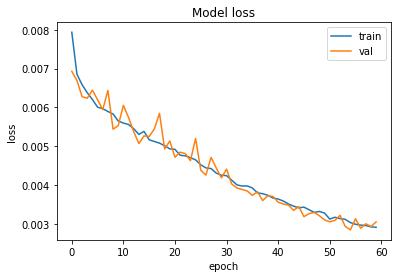

In [26]:
############## PLOT MODEL LOSS ###################

plt.plot(M.history["loss"])
plt.plot(M.history["val_loss"])
# plt.plot(M.history["val_accuracy"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.savefig('/home/kkjk/LSTM/Co-ordinates_mouse_cursor_GT_prediction/Model_loss.png')
plt.show()

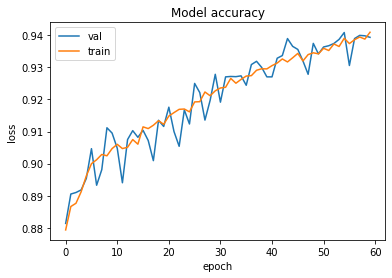

In [27]:
############## PLOT MODEL ACCURACY ###################
plt.plot(M.history["val_accuracy"])
plt.plot(M.history["accuracy"])
plt.title("Model accuracy")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["val", "train"], loc="best")
plt.savefig('/home/kkjk/LSTM/Co-ordinates_mouse_cursor_GT_prediction/Model_accuracy.png')
plt.show()

In [21]:
############################# PREDICTIONS #######################
N_train_val = 57120

### test on second half of users ######

test_data = complete_data[N_train_val:size] # from test dataset
print('Test data:', test_data.shape)
test_label = complete_label[N_train_val:size]
print('Test label:', test_label.shape)



l_X = []
Mouse_X = []
cursor_X = []
Fix_X = []
l_Y = []
Mouse_Y = []
cursor_Y = []
Fix_Y = []

test_ds = np.reshape(test_data,(size-N_train_val,window_size,4))

### model prediction #####
l=model.predict(test_ds)

for check in range((size-N_train_val)):
    Mouse_X.append(test_data[check][59][0]*1920)
    cursor_X.append(test_data[check][59][1]*1920)
    Fix_X.append(test_label[check][0]*1920)
    l_X.append(l[check][0]*1920)
    Mouse_Y.append(test_data[check][59][2]*1200)
    cursor_Y.append(test_data[check][59][3]*1200)
    Fix_Y.append(test_label[check][1]*1200)
    l_Y.append(l[check][1]*1200)
      

Test data: (26180, 60, 4)
Test label: (26180, 2)


In [22]:
#### print one pred to check ########
print(l_X[12919:12920],l_Y[12919:12920])
print(Fix_X[12919:12920],Fix_Y[12919:12920])
print(Mouse_X[12919:12920],Mouse_Y[12919:12920])
print(cursor_X[12919:12920],cursor_Y[12919:12920])


[742.7317428588867] [405.27520179748535]
[474.0] [256.0]
[435.22807017543795] [284.77192982456205]
[790.2226940898756] [347.4077810806083]


In [23]:
### Predictions to array format ###########

Mouse_X =np.array(Mouse_X)
cursor_X =np.array(cursor_X)
Fix_X=np.array(Fix_X)
l_X=np.array(l_X)

Mouse_Y =np.array(Mouse_Y)
cursor_Y =np.array(cursor_Y)
Fix_Y=np.array(Fix_Y)
l_Y=np.array(l_Y)

In [25]:
############ SAVE CO-ORDINATES TO CSV FILES #########################

print('Testset size',size-N_train_val)

pd.DataFrame(cursor_X).to_csv("/home/kkjk/LSTM/Co-ordinates_mouse_cursor_GT_prediction/cursor_XX_26180.csv",  mode='a', header=None, index=None)
pd.DataFrame(Mouse_X).to_csv("/home/kkjk/LSTM/Co-ordinates_mouse_cursor_GT_prediction/mouse_XX_26180.csv",  mode='a', header=None, index=None)
pd.DataFrame(l_X).to_csv("/home/kkjk/LSTM/Co-ordinates_mouse_cursor_GT_prediction/prediction_XX_26180.csv",  mode='a', header=None, index=None)

pd.DataFrame(cursor_Y).to_csv("/home/kkjk/LSTM/Co-ordinates_mouse_cursor_GT_prediction/cursor_YY_26180.csv",  mode='a', header=None, index=None)
pd.DataFrame(Mouse_Y).to_csv("/home/kkjk/LSTM/Co-ordinates_mouse_cursor_GT_prediction/mouse_YY_26180.csv",  mode='a', header=None, index=None)
pd.DataFrame(l_Y).to_csv("/home/kkjk/LSTM/Co-ordinates_mouse_cursor_GT_prediction/prediction_YY_26180.csv",  mode='a', header=None, index=None)

pd.DataFrame(Fix_X).to_csv("/home/kkjk/LSTM/Co-ordinates_mouse_cursor_GT_prediction/GT_Fix_XX_26180.csv",  mode='a', header=None, index=None)
pd.DataFrame(Fix_Y).to_csv("/home/kkjk/LSTM/Co-ordinates_mouse_cursor_GT_prediction/GT_Fix_YY_26180.csv",  mode='a', header=None, index=None)

26180


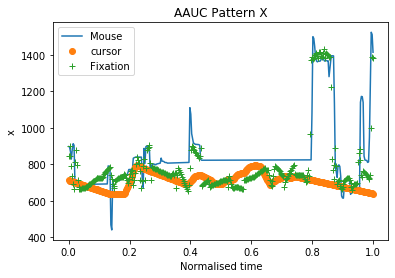

In [40]:
######                       AAUC PATTERN: FIXATION X                 ###############

Time_values = np.linspace(0, 1, num=340)

########### Split tasks 1 users to plot ####################
###############
 
# plt.plot(Time_values,l_X[0:340])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,Mouse_X[0:340])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,cursor_X[0:340],'o')
plt.plot(Time_values,l_X[0:340,'+'])
# plt.plot(Time_values,Fix_X[0:340],'+')

plt.title('AAUC Pattern X Fixation')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Mouse","cursor","Prediction"], loc="best") #, "Prediction"]''')
plt.savefig('AAUC_fixation.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

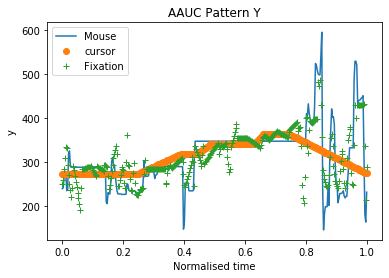

In [39]:
######                       AAUC PATTERN: FIXATION Y                ###############

Time_values = np.linspace(0, 1, num=340)

########### Split tasks 1 users to plot ####################

 
# plt.plot(Time_values,l_X[0:340])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,Mouse_Y[0:340])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,cursor_Y[0:340],'o')
plt.plot(Time_values,Fix_Y[0:340],'+')

plt.title('AAUC Pattern Y Fixation')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Mouse","cursor","Fixation"], loc="best") #, "Prediction"]''')
plt.savefig('AAUC_fixation_Y.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

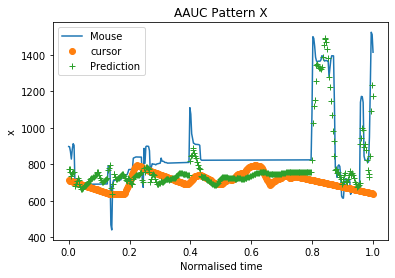

In [41]:
######                       AAUC PATTERN: PREDICTION X                 ###############

Time_values = np.linspace(0, 1, num=340)

########### Split tasks 1 users to plot ####################
###############
 
# plt.plot(Time_values,l_X[0:340])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,Mouse_X[0:340])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,cursor_X[0:340],'o')
plt.plot(Time_values,l_X[0:340],'+')
# plt.plot(Time_values,Fix_X[0:340],'+')

plt.title('AAUC Pattern X Prediction')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Mouse","cursor","Prediction"], loc="best") #, "Prediction"]''')
plt.savefig('AAUC_PREDICTION_x.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

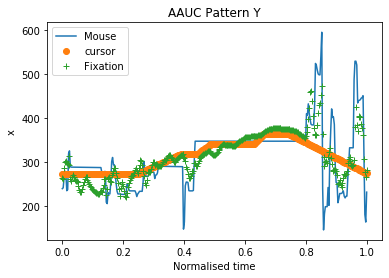

In [42]:
######                       AAUC PATTERN: PREDICTION Y                ###############

Time_values = np.linspace(0, 1, num=340)

########### Split tasks 1 users to plot ####################

 
# plt.plot(Time_values,l_X[0:340])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,Mouse_Y[0:340])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,cursor_Y[0:340],'o')
plt.plot(Time_values,l_Y[0:340],'+')
# plt.plot(Time_values,Fix_Y[0:340],'+')


plt.title('AAUC Pattern Y Prediction')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Mouse","cursor","Fixation"], loc="best") #, "Prediction"]''')
plt.savefig('AAUC_prediction_Y.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

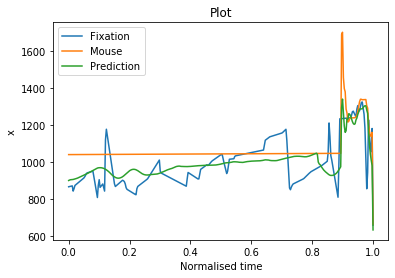

In [36]:
######                        TEMPORAL PLOT TO VISUALISE PREDICTION                  ###############

plt.plot(Time_values,Fix_X[341:681])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,Mouse_X[341:681])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,l_X[341:681])  ##### Plot interpolated X and Y with sampled time points
plt.title('Plot')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Fixation", "Mouse", "Prediction"], loc="best")

plt.show()

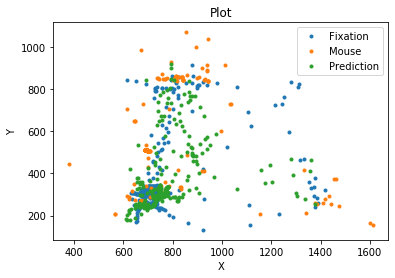

In [37]:
######          VISUALIZING PREDICITONS: SPATIAL                    ###############
window1 = 681
window2 = 1021

plt.plot(Fix_X[window1:window2],Fix_Y[window1:window2],'.')  ##### Plot GROUND TRUTH
plt.plot(Mouse_X[window1:window2],Mouse_Y[window1:window2],'.')  ##### Plot MOUSE
# plt.plot(cursor_X[window1:window2],cursor_Y[window1:window2],'.')  ##### Plot CURSOR
plt.plot(l_X[window1:window2],l_Y[window1:window2],'.')  ##### Plot PREDICTION
plt.title('Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(["Fixation", "Mouse", "Prediction"], loc="upper right")

plt.show()